In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [4]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

### Source Code Citation: 
https://www.kaggle.com/code/asilpoyrazahin/tusimple-lane-detection

### Loading the dataset

In [5]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


### Dataset Information

#### Dataset Size
3626 video clips, 3626 labelled frames. 
Information of each clip: 20 frames for each one.

#### Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----0313-1/60/1.jpg	# Sequential images for the clip, Each folder within 0313-1/# holds 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data for lanes

In [7]:
### Code to assert a specific folder related to 

IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [8]:
### Function to create directories within the dataset folder:

def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [7]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [9]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder to simplify training or dataset access.
"""
#-----------------------------------------------------------------------------------------
"""
Due to the dataset structure of the training set (dataset\lanes\TUSimple\train_set\clips\0313-1\#), 
First, we grab the image and mask associated with the 20th frame from each of the 3,626 folders in the train_set directory.
Then, we take that 20th image/mask, and store them in the IMAGE_FOLDER and MASK_FOLDER folder we created previously.
The purpose of this is because the dataset labels.json files are only for the 20th frame of each of the training clips. 
## Label Data Format
Each json line in 'label_data.json' is the label data for __the last (20th) frame__ of this clip.

"""
#-----------------------------------------------------------------------------------------

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [9]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [10]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

"""
For the ease of use of the one JSON file, we combine the json file into one dataframe for ease of use. 
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
print("""
{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}
""")
df_json.head()


{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}



lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [12]:
# create function for generating masks
"""
1. Creates an empty black mask image (728x1280).
2. Extracts lane info (lanes, h_samples) and the raw file path.
3. For each lane: Removes invalid points (-2).
5. Pairs valid (x, y) coordinates into lane points.
6. Draws a white polyline (thickness 15 px) on the mask.
7. Builds an output filename from the raw file path (e.g., 0313-1_5160.jpg).
8. Saves the mask image to the MASK FOLDER Previously created.
"""
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [12]:
# generate masks
from tqdm import tqdm  #   Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:10<00:00, 362.44it/s]


In [13]:

"""
Builds file paths for the road image (IMAGE_FOLDER) and its corresponding mask (MASK_FOLDER).

Reads the road image and converts it from BGR (OpenCV default) to RGB (for correct colors).

Reads the mask image.

Creates a Matplotlib figure with two subplots side by side.

Left subplot: shows the road image with the title "Road Image".

Right subplot: shows the mask in grayscale with the title "Ground Truth Mask".

Displays both images together for visual comparison.
"""
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

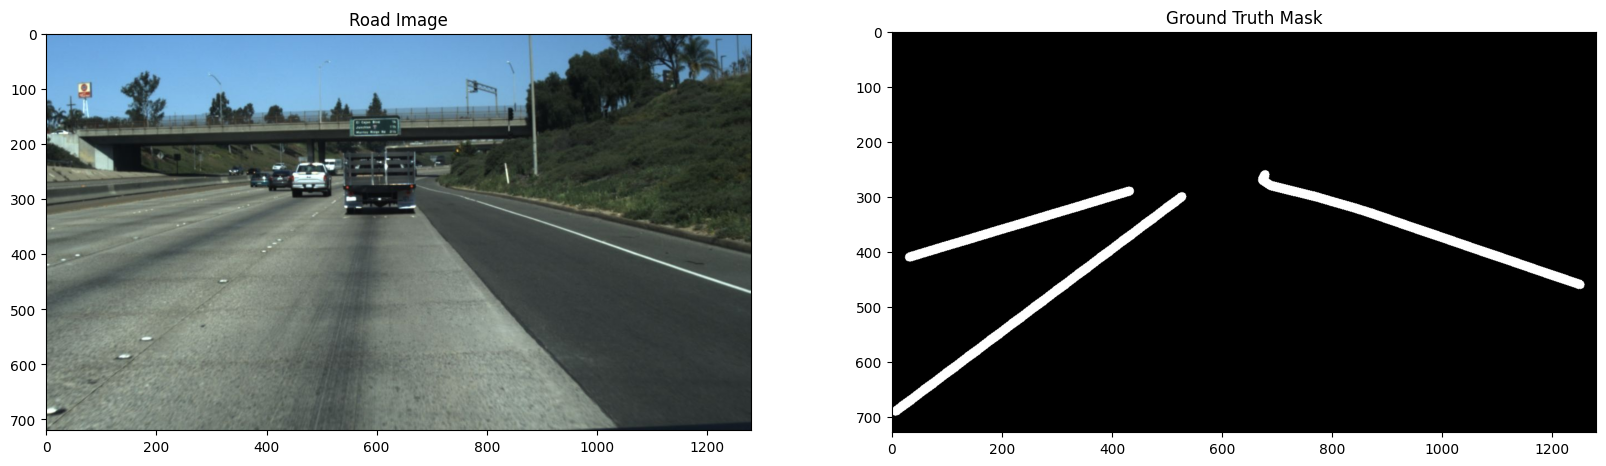

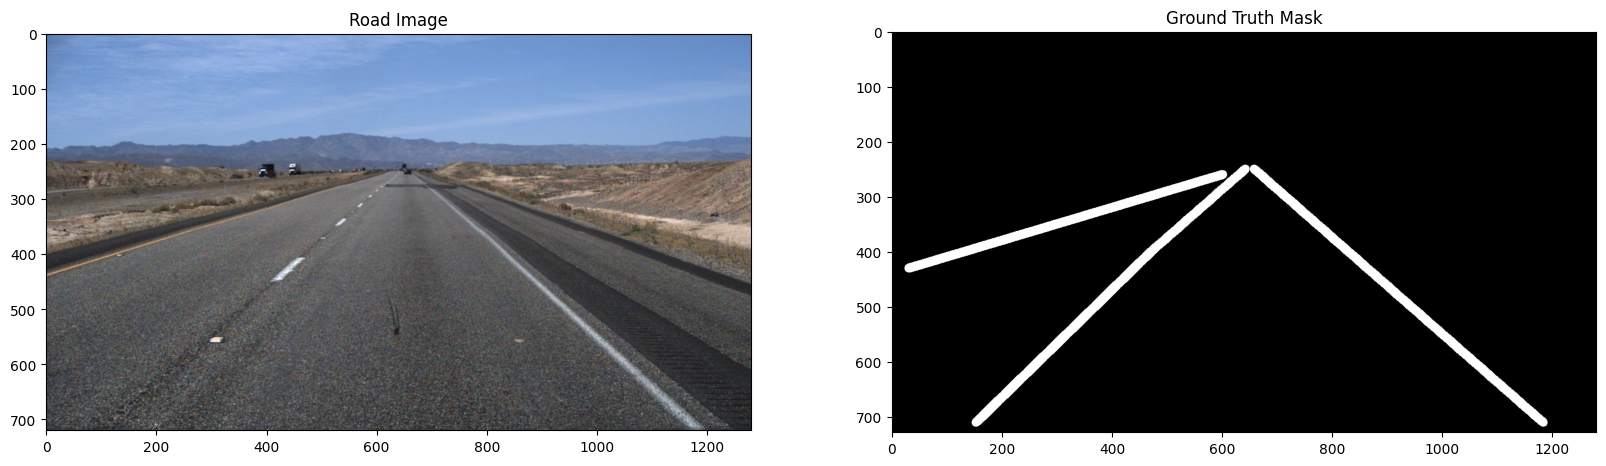

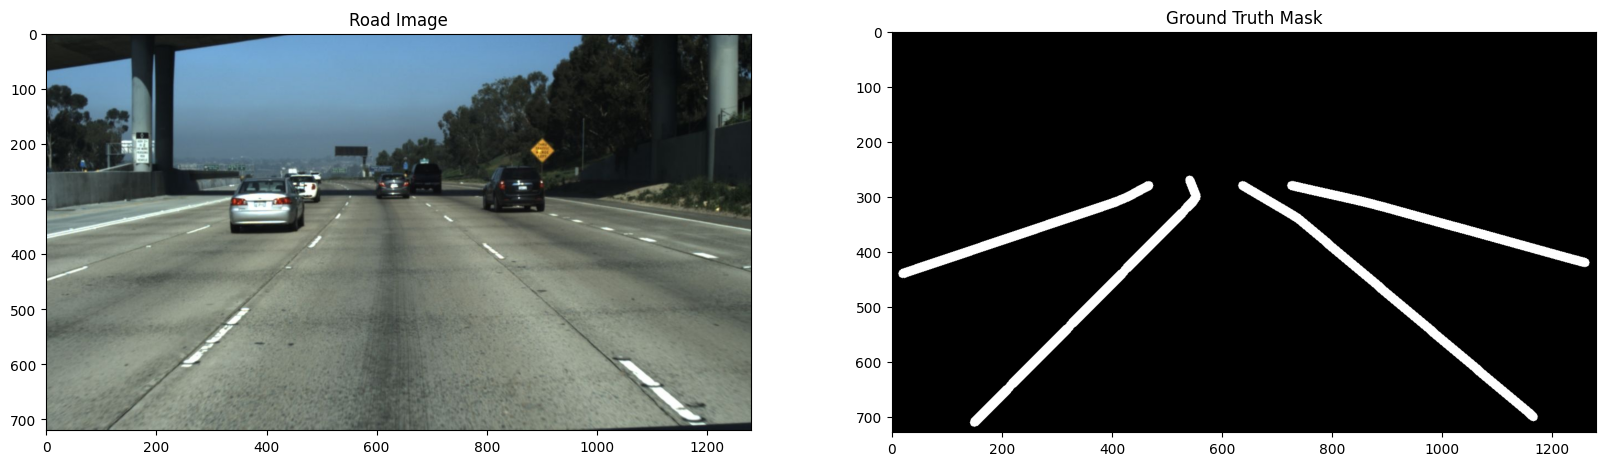

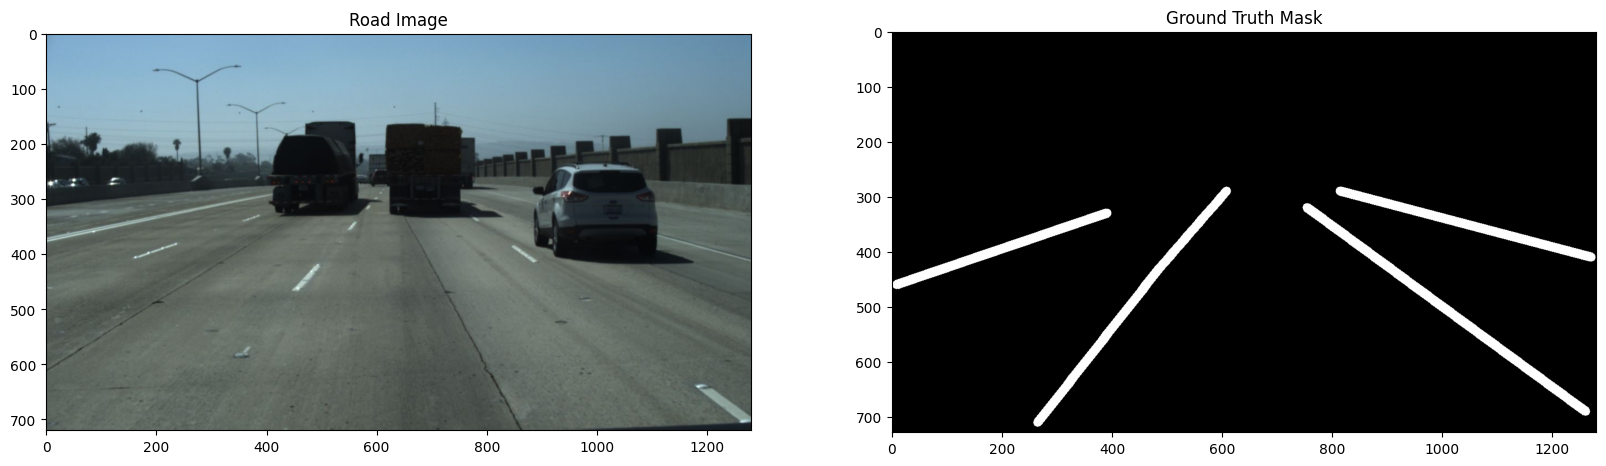

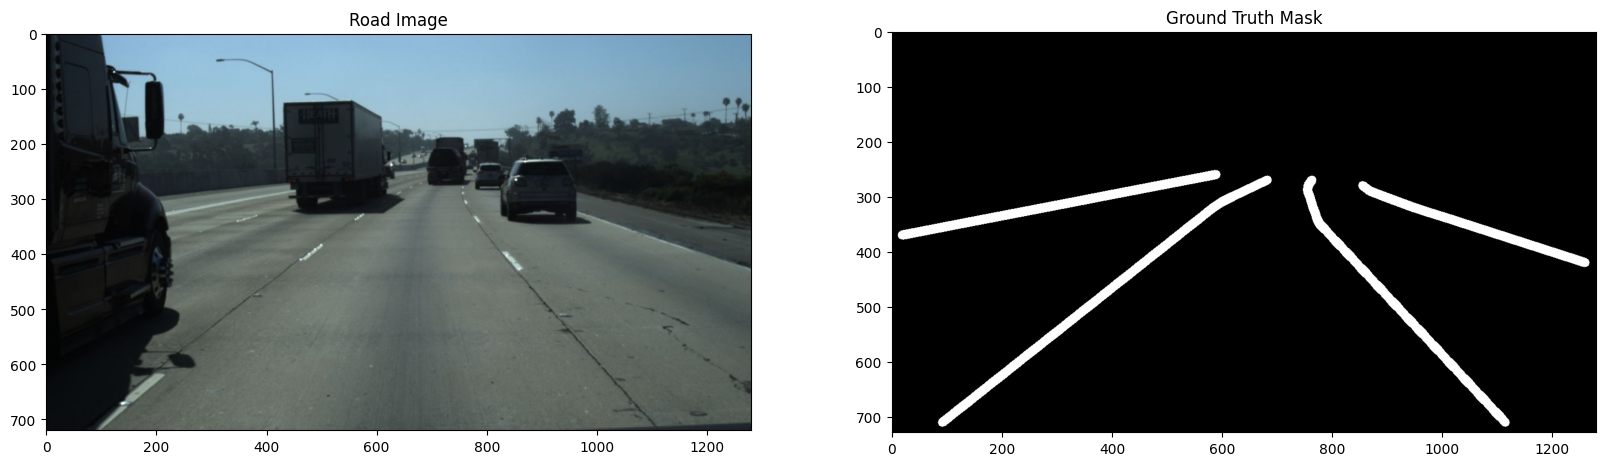

In [14]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [15]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


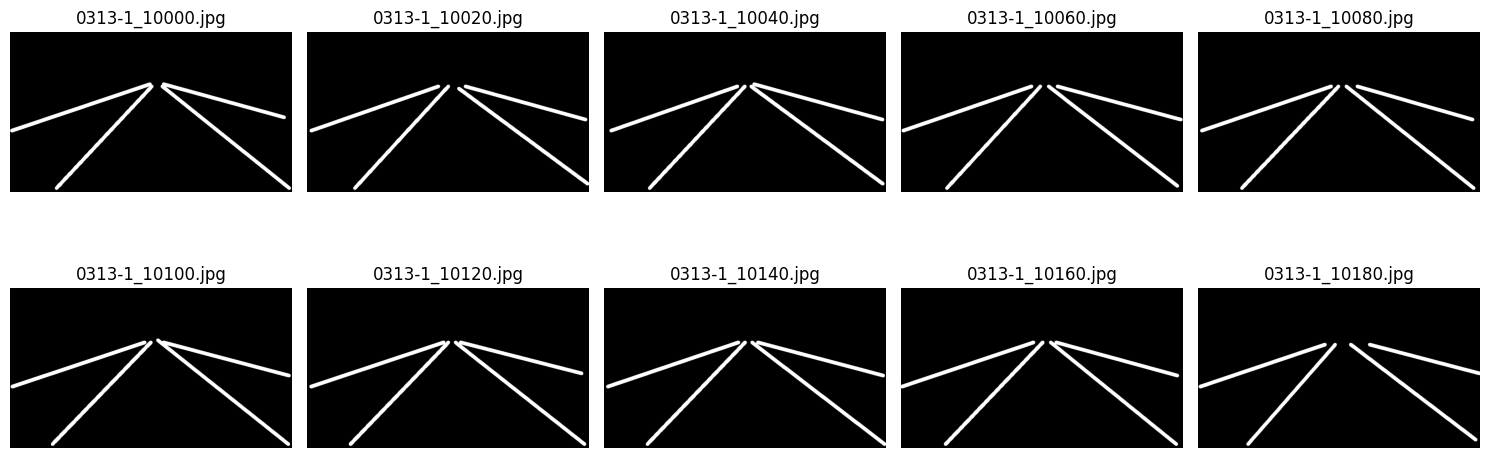

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

# List all mask image files (sorted for consistency)
mask_files = sorted([
    f for f in os.listdir(MASK_FOLDER) if f.endswith(('.png', '.jpg'))
])[:10]

# Plot the first 10 masks
plt.figure(figsize=(15, 6))

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [16]:
# Creating new directories to grab from IMAGE_FOLDER and MASK_FOLDER

lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [17]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [20]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for training and validation
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### UNUSED CODE

### MODEL CREATION

In [25]:
def display_sample(image_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    titles = ["Image", "True Mask", "Predicted Mask"]
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        img = tf.clip_by_value(image_list[i], 0, 1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()  #   free up memory

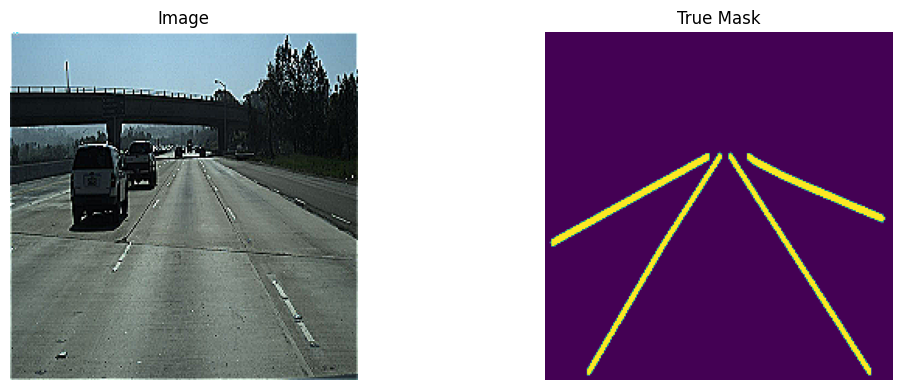

In [32]:
for image, mask in lane_train_dataset.take(1):
    display_sample([image[0], mask[0]])

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

"""
Main: Lightweight semantic segmentation model for lane detection
    built on MobileNetV2 as the encoder and a simple upsampling decoder

    Model Components:
1. Encoder (Feature Extractor)
    Uses MobileNetV2 from torchvision.models.
    Pretrained on ImageNet if pretrained=True.
    Extracts features up to the final convolution block (m.features).

2. Decoder (Segmentation Head)
    No skip connections (unlike U-Net) → lightweight and faster, but less spatial detail.
    Sequence of ConvTranspose2d (upsampling by 2) + Conv2d blocks.
    After each upsample, features are refined with Conv → BN → ReLU.
        Channel progression: 1280 → 256 → 128 → 64 → 32 → 1
    Spatial resolution progression (starting from 7×7): → 14 → 28 → 56 → 112
    Final output before interpolation: (B, 1, 112, 112) logits.
    
"""

class LaneSegOnlyMobileNetV2(nn.Module):
    def __init__(self, pretrained=True, freeze_stem=False):
        super().__init__()
        # ---- Encoder: MobileNetV2 ----
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.mobilenet_v2(weights=weights)

        # Feature extractor (ends at last conv-bn-relu block)
        self.encoder = m.features              # output: (B, 1280, 7, 7) for 224x224
        enc_out_ch = 1280

        if freeze_stem:
            # freeze early, cheap speed/regularization trick
            for p in list(self.encoder.parameters())[:]:
                p.requires_grad = False

        # ---- Lightweight decoder (no skip connections) ----
        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(enc_out_ch, 256, kernel_size=2, stride=2),  # 7 -> 14
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),         # 14 -> 28
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),          # 28 -> 56
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),           # 56 -> 112
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            # Software design only upsamples to 112x112 (Half) becuase of easier hardware implementation.  
            # to get back to the full start resolution in the interpolation
            nn.Conv2d(32, 1, kernel_size=1),  # logits (B,1,112,112)
        )

    def forward(self, x):
        #Stores original height and width.
        H, W = x.shape[-2:]
        
        #Pass input x through MobileNetV2 encoder.
            #Output: compressed, high-level features.
        feats = self.encoder(x)                 # (B,1280,7,7) at 224x224

        #Output: compressed, high-level features.
            #Produces logits for one segmentation class (lane vs background).
        seg   = self.seg_head(feats)           # (B,1,112,112)
        
        """
        This upsamples the segmentation logits from (B,1,112,112) to match the **original input size (H, W)** (e.g., (B,1,224,224)` if input was 224×224).
        Interpolation is basically a resizing operation where
        Bilinear smoothly blend neighboring pixels to get a smoother mask.
        So here, interpolation = “resize the predicted mask to the original image resolution.”
        """
        seg   = F.interpolate(seg, size=(H, W), mode="bilinear", align_corners=False)
        #Returns per-pixel logits
        return seg


In [34]:
#model = LaneSegOnly().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneSegOnlyMobileNetV2(pretrained=True).to(device)

#output_seg = model(torch.randn(4, 3, 224, 224)).to(device)  # batch of 4
#print(output_seg.shape)  # -> (4, 1, 360, 640)

In [62]:
import os
import cv2
import torch
from torch.utils.data import Dataset

import os
import cv2
import torch
from torch.utils.data import Dataset

"""
Defines a custom PyTorch Dataset for the TuSimple lane segmentation dataset.

Inputs:
images_dir → folder with RGB road images.
masks_dir → folder with binary lane masks.
file_list → list of filenames to load.
transform (optional) → Albumentations-style augmentations.
include_class (optional) → if True, also returns a dummy class label.


__getitem__:
Loads an image and converts it from BGR → RGB.
Loads the corresponding mask in grayscale.
Resizes both to 224×224 (image with bilinear interpolation, mask with nearest neighbor).
Applies augmentations if provided (on both image & mask).
Binarizes mask to values {0,1}.
Converts:
Image → PyTorch tensor (3, H, W) normalized to [0,1].
Mask → PyTorch tensor (1, H, W) of floats.

Returns:
(image_tensor, mask_tensor) normally.
(image_tensor, dummy_class, mask_tensor) if include_class=True.
"""


class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None, include_class=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.include_class = include_class  # if True, returns (img, 0, mask)

        # Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Resize to model output (360x640)
        img  = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)       # image
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST) # 640, 360

        # --- Apply transforms (Albumentations-style) ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Binarize after transforms to get {0,1} as float
        mask = (mask > 127).astype("float32")

        # --- Convert to tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0   # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()             # (1, H, W)

        if self.include_class:
            dummy_class = torch.tensor(0, dtype=torch.long)
            return img_tensor, dummy_class, mask_tensor
        else:
            return img_tensor, mask_tensor

In [36]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [37]:
images = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [38]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [39]:
from torch.utils.data import DataLoader
"""
Batch Size: Split the dataset into mini-batches of images + masks.
Batch size = 16: Each training step feeds 16 images + 16 masks through the model

Gen Rule of Thumb: Smaller batch size → noisier updates, but less memory, can help generalization\
                    Larger batch size → smoother updates, faster on GPU, but needs more memory.
"""


lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)


In [63]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [64]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [65]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [66]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Device Capability:", torch.cuda.get_device_capability(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Allocated Memory (MB):", round(torch.cuda.memory_allocated(i) / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print(" No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
cuDNN version: 90100
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Device Capability: (8, 6)
Total Memory (MB): 8191.38
Allocated Memory (MB): 781.78
Cached Memory (MB): 854.0


In [67]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training Model: Only Rerun When ready

### Training Model: Only Rerun When ready

### Training Model: Only Rerun When ready

In [48]:
import torch
import torch.nn.functional as F

from tqdm import tqdm

#Moves the model to GPU if available, otherwise runs on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Loss function = Binary Cross-Entropy with logits
criterion_seg = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#GradScaler: does mixed precision training (saves memory, speeds up training).
scaler = torch.amp.GradScaler(device.type)

#cudnn.benchmark = True: lets PyTorch pick the fastest algorithm for your GPU.
torch.backends.cudnn.benchmark = True

EPOCHS = 250

for epoch in range(EPOCHS):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for images, masks in tqdm(lane_train_loader, desc="Train", leave=True):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        
        #############################################################################################
        """
        1. Reset gradients.
        2. Run the model forward pass → predict segmentation logits.
        3. If the predicted mask size doesn’t match the ground-truth mask, resize it (interpolation).
        4. Compute loss = how wrong the predictions are compared to ground truth.
        """
        #############################################################################################
        with torch.amp.autocast(device.type):   
            out_seg = model(images)
            if out_seg.shape[-2:] != masks.shape[-2:]:
                out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion_seg(out_seg, masks)
        ################################################################################################
        
        # loss.backward() computes gradients of all weights
        scaler.scale(loss).backward() #scaler makes sure gradients are properly scaled for mixed precision
        # optimizer.step() updates the weights.
        scaler.step(optimizer)
        scaler.update()

        # Traian Loss: The error the model makes on the training set during the current epoch
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(lane_val_loader, desc="Val", leave=True):
            images = images.to(device, non_blocking=True)
            masks  = masks.to(device, non_blocking=True).float()

            with torch.amp.autocast(device.type):
                out_seg = model(images)
                if out_seg.shape[-2:] != masks.shape[-2:]:
                    out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion_seg(out_seg, masks)
            
            # The error your model makes on the validation set (data it has never see
            # Validation loss ↓ = model is learning general patterns (not memorizing).
            val_loss += loss.item()

    avg_val_loss = val_loss / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")


Epoch 1/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0927


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.11it/s]


Val Loss: 0.0977

Epoch 2/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0791


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0891

Epoch 3/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.26it/s]


Train Loss: 0.0693


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0828

Epoch 4/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.26it/s]


Train Loss: 0.0603


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.13it/s]


Val Loss: 0.0767

Epoch 5/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0537


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.12it/s]


Val Loss: 0.0728

Epoch 6/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0491


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0711

Epoch 7/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.39it/s]


Train Loss: 0.0453


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.0681

Epoch 8/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.39it/s]


Train Loss: 0.0422


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.0671

Epoch 9/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0388


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.0645

Epoch 10/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0366


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.0662

Epoch 11/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0342


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.0649

Epoch 12/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.38it/s]


Train Loss: 0.0324


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.15it/s]


Val Loss: 0.0651

Epoch 13/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0307


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.0653

Epoch 14/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0296


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.12it/s]


Val Loss: 0.0653

Epoch 15/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0288


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.0649

Epoch 16/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0271


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.0645

Epoch 17/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.38it/s]


Train Loss: 0.0261


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.0651

Epoch 18/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.34it/s]


Train Loss: 0.0252


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0663

Epoch 19/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0245


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.0673

Epoch 20/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0235


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.0664

Epoch 21/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0232


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.98it/s]


Val Loss: 0.0678

Epoch 22/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0227


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.0685

Epoch 23/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.34it/s]


Train Loss: 0.0218


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.0675

Epoch 24/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0218


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.06it/s]


Val Loss: 0.0686

Epoch 25/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0211


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.13it/s]


Val Loss: 0.0684

Epoch 26/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0208


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.0709

Epoch 27/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0199


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.0714

Epoch 28/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.34it/s]


Train Loss: 0.0200


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.0698

Epoch 29/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.34it/s]


Train Loss: 0.0191


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.0708

Epoch 30/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0191


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.0727

Epoch 31/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0187


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.13it/s]


Val Loss: 0.0738

Epoch 32/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.28it/s]


Train Loss: 0.0182


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.0745

Epoch 33/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0181


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.05it/s]


Val Loss: 0.0731

Epoch 34/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0175


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.04it/s]


Val Loss: 0.0743

Epoch 35/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0175


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.08it/s]


Val Loss: 0.0759

Epoch 36/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0171


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0747

Epoch 37/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0172


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.0746

Epoch 38/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0169


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.0767

Epoch 39/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0164


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.09it/s]


Val Loss: 0.0776

Epoch 40/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0164


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0767

Epoch 41/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0167


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.08it/s]


Val Loss: 0.0767

Epoch 42/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0160


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.0789

Epoch 43/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0158


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.11it/s]


Val Loss: 0.0797

Epoch 44/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0160


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.03it/s]


Val Loss: 0.0782

Epoch 45/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0154


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.08it/s]


Val Loss: 0.0808

Epoch 46/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0152


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.12it/s]


Val Loss: 0.0813

Epoch 47/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0151


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.01it/s]


Val Loss: 0.0815

Epoch 48/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0147


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0817

Epoch 49/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0147


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.06it/s]


Val Loss: 0.0835

Epoch 50/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0151


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0783

Epoch 51/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0148


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0826

Epoch 52/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0146


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.05it/s]


Val Loss: 0.0853

Epoch 53/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0146


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.0835

Epoch 54/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0145


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.92it/s]


Val Loss: 0.0826

Epoch 55/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0140


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.74it/s]


Val Loss: 0.0836

Epoch 56/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0141


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.45it/s]


Val Loss: 0.0856

Epoch 57/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0140


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.0836

Epoch 58/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.53it/s]


Train Loss: 0.0138


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.0851

Epoch 59/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0136


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.0866

Epoch 60/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0134


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.54it/s]


Val Loss: 0.0871

Epoch 61/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0133


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.0859

Epoch 62/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.39it/s]


Train Loss: 0.0135


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.0867

Epoch 63/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.25it/s]


Train Loss: 0.0134


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.0885

Epoch 64/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0134


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.17it/s]


Val Loss: 0.0889

Epoch 65/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0131


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.0882

Epoch 66/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.26it/s]


Train Loss: 0.0130


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.0897

Epoch 67/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0128


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.17it/s]


Val Loss: 0.0877

Epoch 68/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0128


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.0879

Epoch 69/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0128


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.0869

Epoch 70/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0127


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.15it/s]


Val Loss: 0.0923

Epoch 71/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0125


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.0887

Epoch 72/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0125


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.0896

Epoch 73/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0122


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.0925

Epoch 74/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0121


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.15it/s]


Val Loss: 0.0925

Epoch 75/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0121


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.0894

Epoch 76/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0119


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.15it/s]


Val Loss: 0.0939

Epoch 77/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0124


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.0913

Epoch 78/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.34it/s]


Train Loss: 0.0123


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.0899

Epoch 79/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.53it/s]


Train Loss: 0.0120


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.0895

Epoch 80/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0118


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.0948

Epoch 81/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.54it/s]


Val Loss: 0.0940

Epoch 82/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0119


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.84it/s]


Val Loss: 0.0951

Epoch 83/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.0968

Epoch 84/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0119


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.0944

Epoch 85/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Val Loss: 0.0942

Epoch 86/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0113


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.51it/s]


Val Loss: 0.0961

Epoch 87/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.53it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Val Loss: 0.0940

Epoch 88/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.0966

Epoch 89/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0116


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.0933

Epoch 90/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0115


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.60it/s]


Val Loss: 0.0966

Epoch 91/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.44it/s]


Train Loss: 0.0114


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.08it/s]


Val Loss: 0.0943

Epoch 92/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0111


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.13it/s]


Val Loss: 0.0977

Epoch 93/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0109


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.09it/s]


Val Loss: 0.0985

Epoch 94/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.24it/s]


Train Loss: 0.0109


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.1003

Epoch 95/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0108


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.0972

Epoch 96/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0111


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.86it/s]


Val Loss: 0.0979

Epoch 97/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0109


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.0996

Epoch 98/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0106


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.1002

Epoch 99/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0108


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.02it/s]


Val Loss: 0.1006

Epoch 100/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0105


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.11it/s]


Val Loss: 0.1009

Epoch 101/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0106


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.1008

Epoch 102/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0106


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.98it/s]


Val Loss: 0.1011

Epoch 103/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0104


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.03it/s]


Val Loss: 0.1010

Epoch 104/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.26it/s]


Train Loss: 0.0103


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0991

Epoch 105/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0102


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.1025

Epoch 106/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0105


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.45it/s]


Val Loss: 0.0995

Epoch 107/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0104


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.1015

Epoch 108/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.45it/s]


Train Loss: 0.0103


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.59it/s]


Val Loss: 0.1012

Epoch 109/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.46it/s]


Train Loss: 0.0101


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Val Loss: 0.1043

Epoch 110/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0103


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.1016

Epoch 111/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.39it/s]


Train Loss: 0.0102


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Val Loss: 0.0998

Epoch 112/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0103


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.48it/s]


Val Loss: 0.1028

Epoch 113/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.46it/s]


Train Loss: 0.0101


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1036

Epoch 114/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0100


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.95it/s]


Val Loss: 0.1045

Epoch 115/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.26it/s]


Train Loss: 0.0101


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.09it/s]


Val Loss: 0.1016

Epoch 116/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.24it/s]


Train Loss: 0.0099


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.1052

Epoch 117/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0099


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Val Loss: 0.1037

Epoch 118/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0098


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.54it/s]


Val Loss: 0.1055

Epoch 119/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0097


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.1052

Epoch 120/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0101


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.1051

Epoch 121/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0099


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.62it/s]


Val Loss: 0.1065

Epoch 122/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.44it/s]


Train Loss: 0.0096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.57it/s]


Val Loss: 0.1076

Epoch 123/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.46it/s]


Train Loss: 0.0094


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.1096

Epoch 124/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.1070

Epoch 125/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.76it/s]


Val Loss: 0.1062

Epoch 126/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0093


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1081

Epoch 127/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:34<00:00,  2.17it/s]


Train Loss: 0.0094


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.34it/s]


Val Loss: 0.1095

Epoch 128/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  3.96it/s]


Train Loss: 0.0096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.1086

Epoch 129/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.1081

Epoch 130/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.50it/s]


Train Loss: 0.0093


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1085

Epoch 131/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0093


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Val Loss: 0.1078

Epoch 132/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.50it/s]


Train Loss: 0.0095


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.1074

Epoch 133/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0093


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.04it/s]


Val Loss: 0.1075

Epoch 134/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.23it/s]


Train Loss: 0.0095


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Val Loss: 0.1090

Epoch 135/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0092


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 0.1079

Epoch 136/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0091


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.95it/s]


Val Loss: 0.1120

Epoch 137/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0090


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.1090

Epoch 138/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.48it/s]


Train Loss: 0.0090


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.1112

Epoch 139/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.50it/s]


Train Loss: 0.0090


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.1125

Epoch 140/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0090


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.60it/s]


Val Loss: 0.1106

Epoch 141/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0089


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.1127

Epoch 142/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0090


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.1094

Epoch 143/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0088


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.56it/s]


Val Loss: 0.1102

Epoch 144/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.44it/s]


Train Loss: 0.0088


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1123

Epoch 145/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0089


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Val Loss: 0.1126

Epoch 146/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0088


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1115

Epoch 147/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.22it/s]


Train Loss: 0.0088


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.02it/s]


Val Loss: 0.1141

Epoch 148/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0091


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.1087

Epoch 149/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0088


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.1138

Epoch 150/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0086


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.1162

Epoch 151/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0086


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1141

Epoch 152/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.61it/s]


Train Loss: 0.0085


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Val Loss: 0.1152

Epoch 153/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0084


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1172

Epoch 154/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0085


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1139

Epoch 155/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0086


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.1127

Epoch 156/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.61it/s]


Train Loss: 0.0087


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.1110

Epoch 157/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0087


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.1108

Epoch 158/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.46it/s]


Train Loss: 0.0087


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.64it/s]


Val Loss: 0.1158

Epoch 159/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0084


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.00it/s]


Val Loss: 0.1154

Epoch 160/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0085


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.1153

Epoch 161/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0084


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.1163

Epoch 162/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.17it/s]


Val Loss: 0.1178

Epoch 163/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.1158

Epoch 164/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0081


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.17it/s]


Val Loss: 0.1205

Epoch 165/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.32it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.17it/s]


Val Loss: 0.1184

Epoch 166/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.48it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1190

Epoch 167/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0083


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.60it/s]


Val Loss: 0.1172

Epoch 168/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.51it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.1192

Epoch 169/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0084


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1199

Epoch 170/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0082


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Val Loss: 0.1183

Epoch 171/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0079


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Val Loss: 0.1204

Epoch 172/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.53it/s]


Train Loss: 0.0083


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.1119

Epoch 173/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0083


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1164

Epoch 174/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0080


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.55it/s]


Val Loss: 0.1211

Epoch 175/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0080


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.75it/s]


Val Loss: 0.1210

Epoch 176/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0081


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.1190

Epoch 177/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0078


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1227

Epoch 178/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0080


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.62it/s]


Val Loss: 0.1197

Epoch 179/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0080


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1196

Epoch 180/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0078


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.1228

Epoch 181/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0079


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.77it/s]


Val Loss: 0.1226

Epoch 182/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0081


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.57it/s]


Val Loss: 0.1221

Epoch 183/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0079


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.73it/s]


Val Loss: 0.1202

Epoch 184/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0080


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Val Loss: 0.1220

Epoch 185/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0078


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.76it/s]


Val Loss: 0.1218

Epoch 186/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1261

Epoch 187/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.65it/s]


Val Loss: 0.1253

Epoch 188/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0078


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1244

Epoch 189/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0077


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.59it/s]


Val Loss: 0.1256

Epoch 190/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Val Loss: 0.1277

Epoch 191/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.55it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.1225

Epoch 192/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.05it/s]


Val Loss: 0.1231

Epoch 193/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.63it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.1262

Epoch 194/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.1258

Epoch 195/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.1274

Epoch 196/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0074


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.76it/s]


Val Loss: 0.1268

Epoch 197/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.1238

Epoch 198/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.61it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1277

Epoch 199/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.64it/s]


Val Loss: 0.1203

Epoch 200/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0076


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.69it/s]


Val Loss: 0.1234

Epoch 201/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.78it/s]


Val Loss: 0.1297

Epoch 202/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0073


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.1294

Epoch 203/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0073


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.62it/s]


Val Loss: 0.1281

Epoch 204/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0073


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.52it/s]


Val Loss: 0.1285

Epoch 205/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0072


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.73it/s]


Val Loss: 0.1315

Epoch 206/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0074


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Val Loss: 0.1267

Epoch 207/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.50it/s]


Train Loss: 0.0073


Val: 100%|████████████████████████████████████████████████████████████████████████| 23/23 [16:53:35<00:00, 2644.17s/it]


Val Loss: 0.1281

Epoch 208/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:15<00:00,  2.70it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.34it/s]


Val Loss: 0.1323

Epoch 209/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:15<00:00,  2.69it/s]


Train Loss: 0.0072


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.92it/s]


Val Loss: 0.1310

Epoch 210/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.09it/s]


Train Loss: 0.0075


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.67it/s]


Val Loss: 0.1279

Epoch 211/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:52<00:00,  3.91it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.54it/s]


Val Loss: 0.1314

Epoch 212/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:50<00:00,  4.07it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.08it/s]


Val Loss: 0.1312

Epoch 213/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.10it/s]


Train Loss: 0.0072


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.73it/s]


Val Loss: 0.1301

Epoch 214/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.16it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.79it/s]


Val Loss: 0.1353

Epoch 215/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.11it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.74it/s]


Val Loss: 0.1292

Epoch 216/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  3.99it/s]


Train Loss: 0.0072


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.08it/s]


Val Loss: 0.1309

Epoch 217/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.0072


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.90it/s]


Val Loss: 0.1326

Epoch 218/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.35it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.1355

Epoch 219/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.1353

Epoch 220/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.60it/s]


Train Loss: 0.0070


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.1330

Epoch 221/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.47it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.56it/s]


Val Loss: 0.1298

Epoch 222/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.45it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.92it/s]


Val Loss: 0.1317

Epoch 223/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.49it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.82it/s]


Val Loss: 0.1326

Epoch 224/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.45it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.03it/s]


Val Loss: 0.1343

Epoch 225/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.56it/s]


Val Loss: 0.1345

Epoch 226/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0068


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.1344

Epoch 227/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.39it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.01it/s]


Val Loss: 0.1343

Epoch 228/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.1327

Epoch 229/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0068


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Val Loss: 0.1324

Epoch 230/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Val Loss: 0.1345

Epoch 231/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0069


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.1346

Epoch 232/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0068


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.1385

Epoch 233/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.1365

Epoch 234/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0070


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 0.1367

Epoch 235/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.44it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.1367

Epoch 236/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.1389

Epoch 237/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0068


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.1370

Epoch 238/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.1400

Epoch 239/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Val Loss: 0.1367

Epoch 240/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0068


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.1346

Epoch 241/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.36it/s]


Train Loss: 0.0070


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.1351

Epoch 242/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0066


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.1409

Epoch 243/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0065


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.1409

Epoch 244/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0066


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.1396

Epoch 245/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0065


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.1384

Epoch 246/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0064


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.1439

Epoch 247/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0067


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.1394

Epoch 248/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.40it/s]


Train Loss: 0.0071


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.1355

Epoch 249/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0065


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.1400

Epoch 250/250


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0064


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]

Val Loss: 0.1412


In [51]:
# === Save model weights ===
torch.save(model.state_dict(), "lane_seg_weights.pth")
print(" Model weights saved to lane_seg_weights.pth")

 Model weights saved to lane_seg_weights.pth


### Loading Pretrained Model

In [52]:
model = LaneSegOnlyMobileNetV2()
model.load_state_dict(torch.load("lane_seg_weights.pth"))
model.to(device)
model.eval()  # set to inference mode

C:\Users\Baron\AppData\Local\Temp\ipykernel_4028\1183639246.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_seg_weights.pth"))


LaneSegOnlyMobileNetV2(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2

In [54]:
# Define test folders (if not already defined)
test_images_dir = lane_test_image_folder
test_masks_dir  = lane_test_mask_folder

# Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

#   Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [55]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss Function (segmentation only) ===
# Since lane segmentation is binary (lane vs background), we use Binary Cross Entropy (BCE)
# Model outputs raw numbers (logits).ss

criterion_seg = nn.BCEWithLogitsLoss()

# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    # y_pred: raw logits -> sigmoid -> threshold -> {0,1}
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop (segmentation only) ===
test_loss = 0.0
dice_total = 0.0

model.eval()

with torch.no_grad():
    for batch in tqdm(lane_test_loader):
        # Support both (images, masks)
        # Load images and ground-truth masks from the test loader.
        if len(batch) == 3:
            images, _, masks = batch
        else:
            images, masks = batch

        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()  # BCEWithLogitsLoss expects float

        # Run images through your segmentation model.
        out_seg = model(images)  # LaneSegOnly returns logits for the mask

        # Compare predictions to ground truth masks using BCEWithLogits.
        loss = criterion_seg(out_seg, masks)
        test_loss += loss.item()

        dice = dice_coefficient(masks, out_seg)
        dice_total += dice.item()

avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print("\ Test Results:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Dice Score: {avg_dice_score:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  2.05it/s]


🧪 Test Results:
Test Loss: 0.1407
Dice Score: 0.7530


In [56]:
import matplotlib.pyplot as plt
import torch

def show_sample_prediction(model, dataset, device, index=0):
    model.eval()

    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # if dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # if dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # Convert to probabilities
        pred_mask = (pred_mask > 0.5).float()     # Threshold at 0.5

    # --- Convert to numpy for visualization ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (C,H,W) → (H,W,C)
    true_np = true_mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    titles = ["Input Image", "Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate([img_np, true_np, pred_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


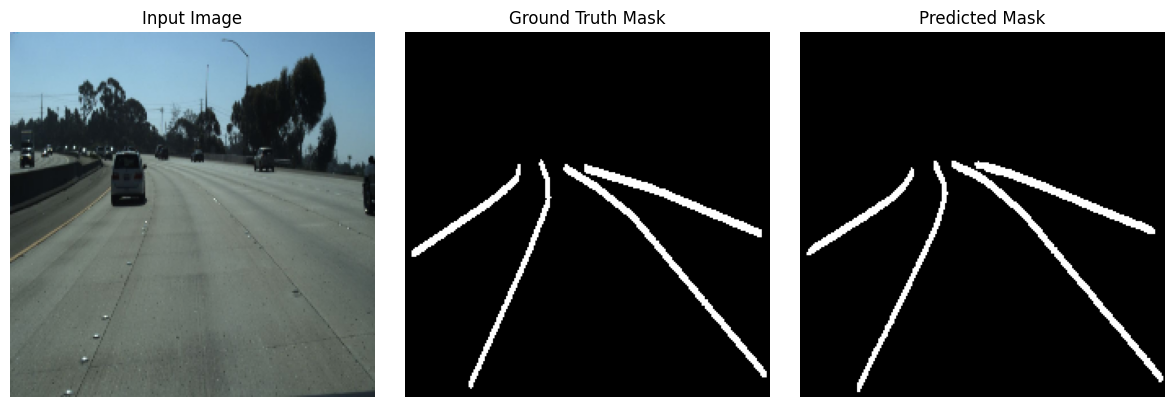

In [57]:
# Example: show first test image prediction
show_sample_prediction(model, lane_test_dataset, device, index=20)

In [58]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # → probabilities
        pred_mask = (pred_mask > 0.5).float()     # → binary mask

    # --- Convert tensors to numpy ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] for display
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Apply overlay to predicted mask regions ---
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


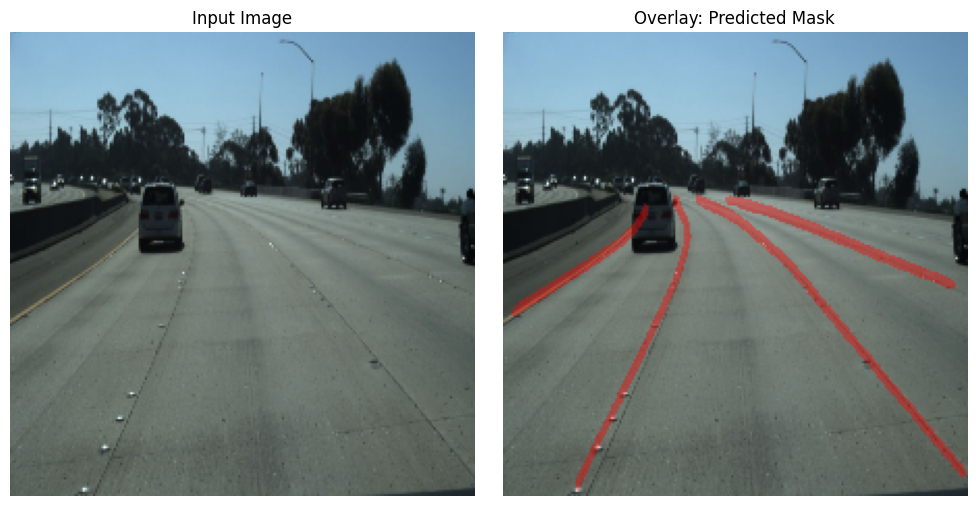

In [59]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=20, alpha=0.4)

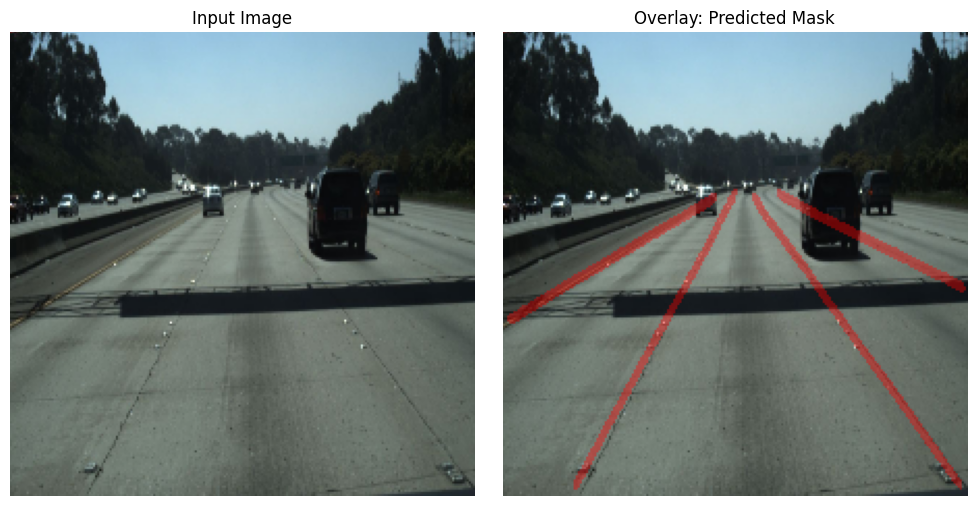

In [60]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=1, alpha=0.4)